In [1]:
crimes <- read.csv('data/crimes.csv')
crimes$sqrtcrimes = round(sqrt(crimes$crimes))
crimes$population = crimes$density * crimes$area
crimes$crimepc = crimes$crimes / crimes$population
head(crimes)

crimes,prbarr,prbpris,polpc,density,area,taxpc,region,pctmin,pctymale,wcon,wsta,wser,wtrd,wfir,name,sqrtcrimes,population,crimepc
3901,0.289696,0.472222,0.0017868,230.71590,423.943,25.69763,central,20.21870,0.0876968,206.4803,236.24,215.7335,182.3330,272.4492,Alamance County,62,97810.391,0.039883288
416,0.202899,0.465753,0.0005939,97.68340,259.994,14.56088,central,7.91632,0.0870046,188.7683,247.38,191.3742,151.4234,202.4292,Alexander County,20,25397.098,0.016379824
91,0.406593,0.500000,0.0008209,41.27659,235.059,18.63060,west,3.16053,0.0738525,147.9290,233.33,158.2278,143.5132,200.3205,Alleghany County,10,9702.434,0.009379090
562,0.431095,0.431373,0.0014327,48.21764,531.452,38.24473,central,47.91610,0.0836378,284.5809,206.07,208.4636,174.2457,207.1006,Anson County,24,25625.361,0.021931398
170,0.631579,0.383333,0.0008353,53.05164,426.135,16.85321,west,1.79619,0.0790580,195.9361,234.75,178.7785,152.7354,209.0301,Ashe County,13,22607.161,0.007519741
275,0.369650,0.226415,0.0019067,59.10931,247.087,22.32144,west,1.54070,0.1063334,199.2377,227.69,176.5392,150.5835,195.3125,Avery County,17,14605.142,0.018828985


In [20]:
options(repr.plot.width = 10, repr.plot.height = 10)
require(lattice)
factor_parameters = c('region')
parameters = c('crimes', 'prbarr', 'prbpris', 'polpc', 'density', 'area', 'taxpc', 'region', 'pctmin', 'pctymale', 'wcon', 'wsta', 'wser', 'wtrd', 'wfir', 'crimepc', 'population')
basedir.name = "plots"
target_parameter = 'crimes'

if (!dir.exists(basedir.name)) {
    dir.create(basedir.name)
}
d = NULL
for (parameters.left in parameters) {
    folder = paste0(basedir.name,"/", parameters.left)
    if (!dir.exists(folder)) {
        dir.create(folder)
    }
    for (parameters.right in parameters) {
        if (parameters.left == parameters.right ||
            (parameters.left != target_parameter && (parameters.right == target_parameter || parameters.right %in% factor_parameters))) {
            next
        }
        
        png(filename=paste0(basedir.name,"/",parameters.left,"/",parameters.right,".png"), pointsize=10, width=1400, height=960, res=300, units="px")
        tryCatch({
            if (parameters.left == target_parameter) {
                models.formulas.strings = if(parameters.right %in% factor_parameters)
                    c(paste0(target_parameter,"~1+",parameters.right))
                else
                    c(paste0(target_parameter,"~1+",parameters.right), 
                      paste0(target_parameter,"~1+I(log(",parameters.right,"))"),
                      paste0(target_parameter,"~1+I(sqrt(",parameters.right,"))"),
                      paste0(target_parameter,"~1+",parameters.right,"+I(",parameters.right,"^2)"),
                      paste0(target_parameter,"~1+",parameters.right,"+I(",parameters.right,"^2)+I(",parameters.right,"^3)"))
        
                models.formulas = sapply(models.formulas.strings, function(str) { as.formula(str) }, simplify = TRUE)

                models = lapply(models.formulas, function(formula) { return(glm(formula, data=crimes, family=poisson(link="log")))})

                plot(crimes[[parameters.right]], crimes[[parameters.left]], xlab = parameters.right, ylab = parameters.left)
                if (!(parameters.right %in% factor_parameters)){
                    righthand.range = range(crimes[[parameters.right]])
                    newdata.x = seq(righthand.range[1], righthand.range[2], (righthand.range[2] - righthand.range[1])/100)
                    newdata.x = data.frame(placeholder = newdata.x)
                    newdata.x[[parameters.right]] = newdata.x$placeholder
                    for (i in 1:length(models)) {
                        points(newdata.x[[parameters.right]], predict(models[[i]], newdata=newdata.x, type="response"), type="l", lwd=1, col=i)
                    }
                }
                # colors: 1=schwarz, 2=rot, 3=grün, 4=dunkelblau, 5=cyan
            }
            else if (parameters.right != target_parameter && !(parameters.right %in% factor_parameters)) {
                dataset = crimes[c(target_parameter,parameters.left, parameters.right)]
                colnames(dataset) = c('response', 'base', 'influence')
                plot = xyplot(response~base|cut(influence,3), data=dataset, layout=c(3,1), xlab=paste0(parameters.left,':',parameters.right), ylab='crimes', panel=function(x,y){
                    panel.xyplot(x,y)
                    model = lm(y~x)
                    if (length(coefficients(model))>2)
                        panel.plot(model) # i think this does not work
                    else
                        panel.abline(lm(y~x))})
                print(plot)
            }
        },
        finally=dev.off()
        )
    }
}

In [17]:
length(coefficients(lm(crimes~region, data=crimes)))

[1] 3

response,base,influence
3901,0.289696,0.472222
416,0.202899,0.465753
91,0.406593,0.500000
562,0.431095,0.431373
170,0.631579,0.383333
275,0.369650,0.226415
1237,0.319665,0.500000
354,0.453258,0.489130
569,0.483986,0.460317
828,0.326196,0.404580


[1] "test"
[1] "test"
[1] "test"

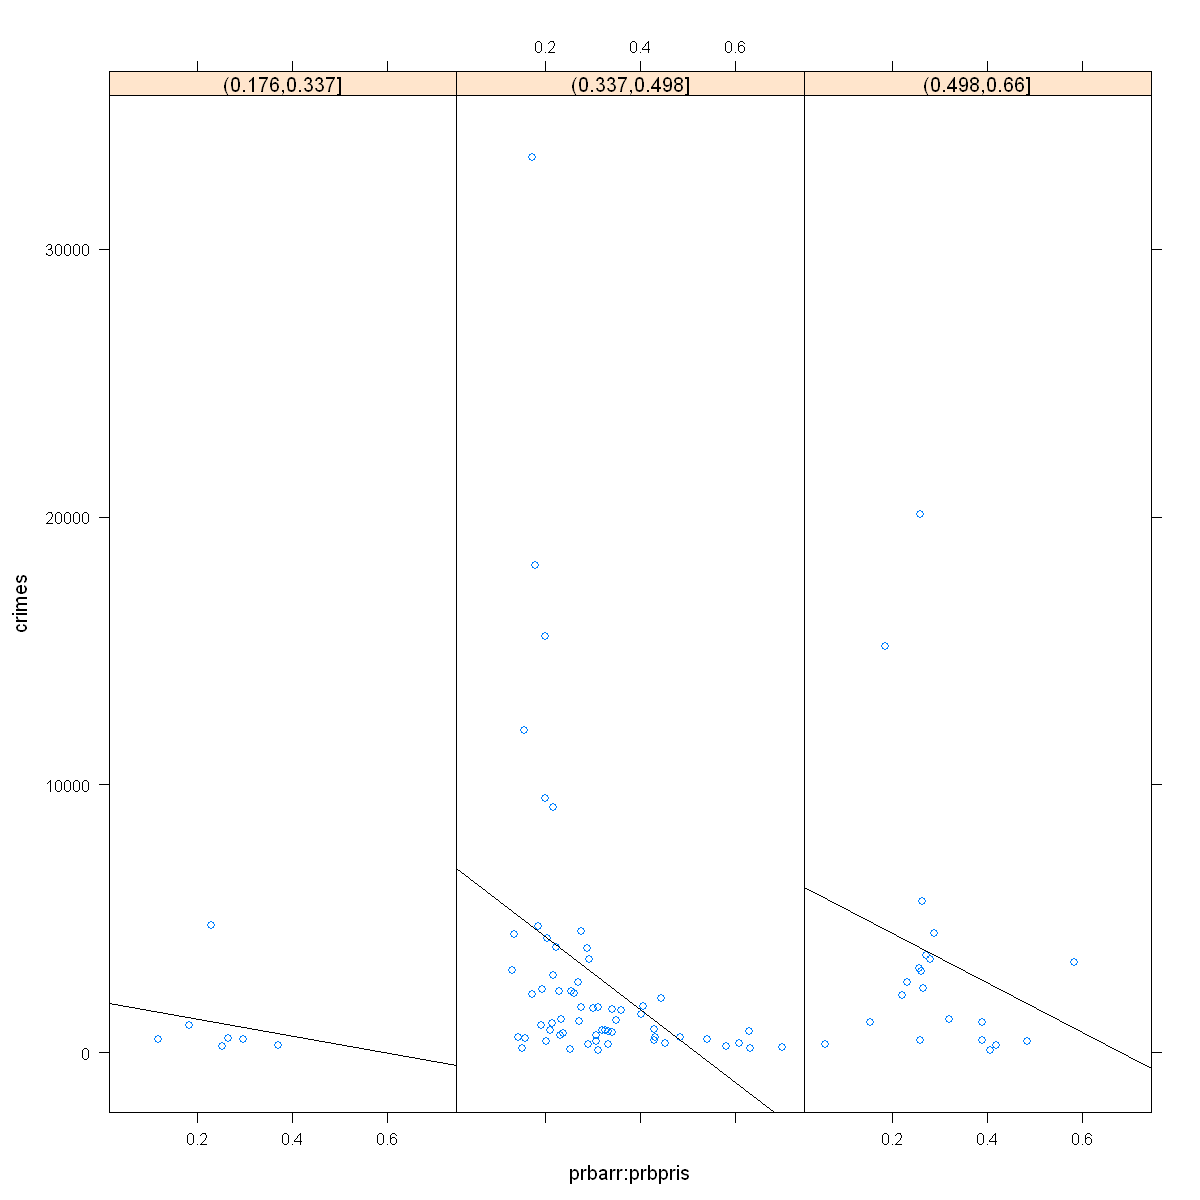

In [5]:
aad
xyplot(response~base|cut(influence,3), data=d, layout=c(3,1), xlab=paste0(parameters.left,':',parameters.right), ylab='crimes', panel=function(x,y){
                    print('test')
                    panel.xyplot(x,y)
                    panel.abline(lm(y~x))})

[1] "test"
[1] "test"
[1] "test"

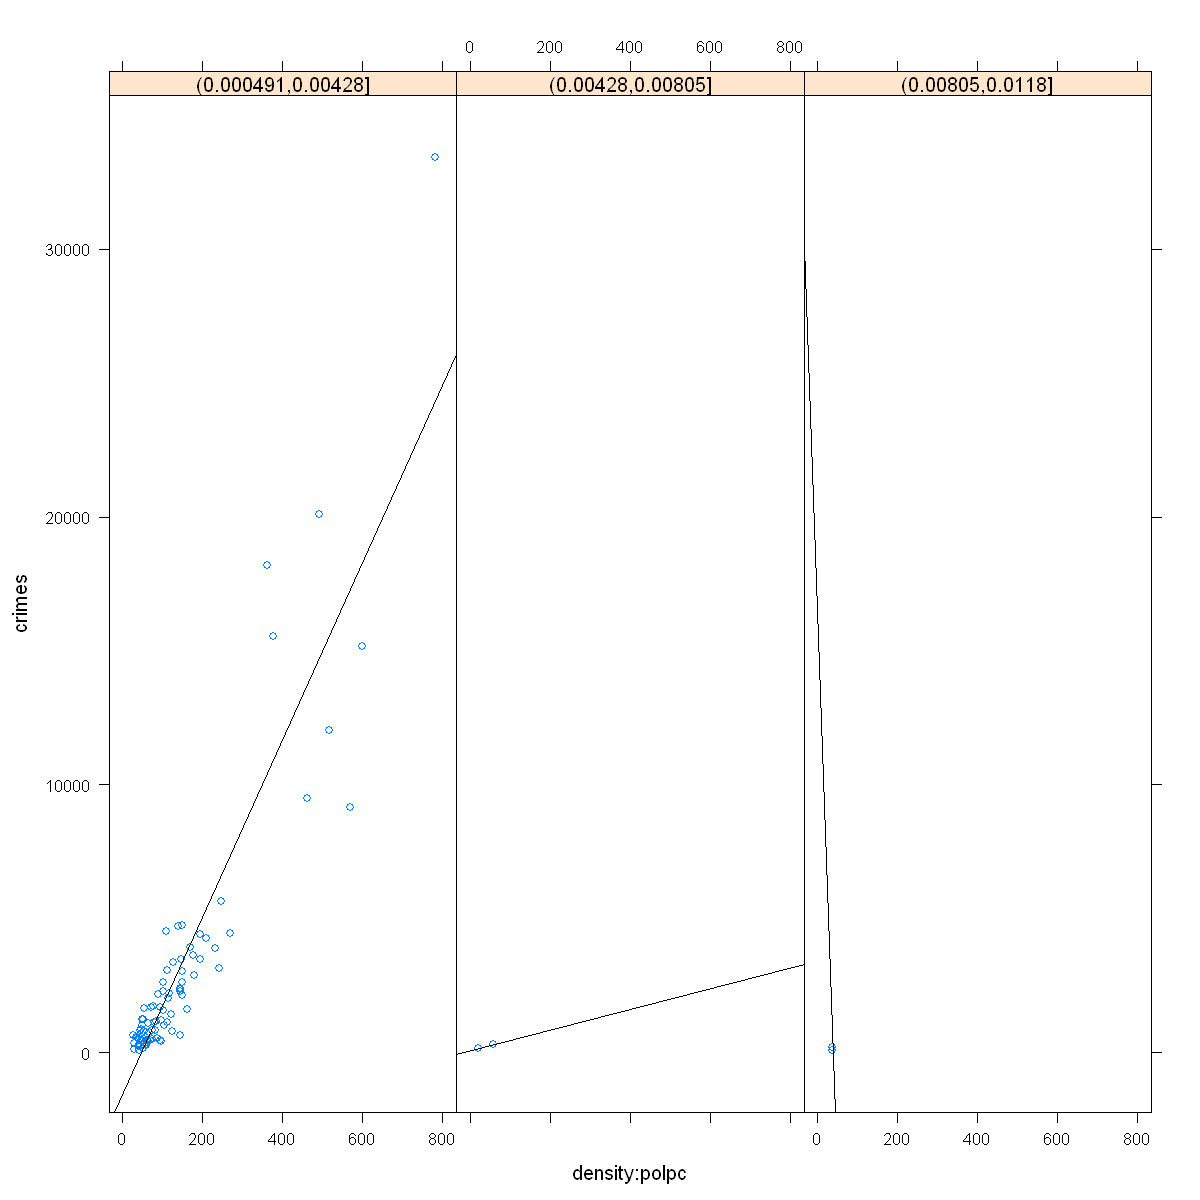

In [4]:
target_parameter = 'crimes'
parameters.left = 'density'
parameters.right = 'polpc'
dataset = crimes[c(target_parameter,parameters.left, parameters.right)]
                colnames(dataset) = c('response', 'base', 'influence')
                xyplot(response~base|cut(influence,3), data=dataset, layout=c(3,1), xlab=paste0(parameters.left,':',parameters.right), ylab='crimes', panel=function(x,y){
                    print('test')
                    panel.xyplot(x,y)
                    panel.abline(lm(y~x))})

In [7]:
dataset = crimes[c('crimes','density', 'polpc')]
colnames(dataset) = c('response', 'base', 'influence')
png(filename="test.png")
xyplot(response~base|cut(influence,3), data=dataset, layout=c(3,1), xlab=paste0(parameters.left,':',parameters.right), ylab='crimes', panel=function(x,y){
    panel.xyplot(x,y)
    panel.abline(lm(y~x))})
dev.off()

png 
  2